In [367]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sb

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

In [345]:
class Data(object):
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
    def predict(self):
        self.clf.fit(self.X, self.y)
        for x, y in zip(self.X,self.y):
            print("{} {}".format(self.clf.predict(x),y))
    
    def validate(self, splits=10, test=0.1):
        cv = ShuffleSplit(n_splits=splits, test_size=test)
        scores = cross_val_score(self.clf, self.X, self.y, cv=cv)
        return scores.mean()
        
    def train_score(self):
        return self.clf.score(self.X,self.y)
        
    def load_data(self, data, threshold=0, num_hours=1):
        # Check market change
        #data['grew'] = np.select([data['pDelta']>threshold,data['pDelta']<-threshold],[1,-1],default=0)
        
        self.x ={}
        self.y ={}
        
        hours = data.timeId.unique()
        hours.sort()
        count = 0
        index = 0
        change = 1
        remap = {}
        
        for hour in hours:
            change *= 1+data.loc[data['timeId']==hour].iloc[0]['pDelta']
            remap[hour] = index
            count += 1
            if count >= num_hours:
                self.x[index] = defaultdict(int)
                if change > 1+threshold:
                    self.y[index] = 1
                elif change < 1-threshold:
                    self.y[index] = -1
                else:
                    self.y[index] = 0
                count = 0
                change = 1
                index += 1
        #handle potential end missing
        if count>0:
            self.x[index] = defaultdict(int)
            if change > 1+threshold:
                self.y[index] = 1
            elif change < 1-threshold:
                self.y[index] = -1
            else:
                self.y[index] = 0
            
            
        wnl = WordNetLemmatizer()
        stemmer = PorterStemmer()
        stopset = stopwords.words('english')
        ignore = str.maketrans('', '', string.punctuation+string.digits)
        for index, row in data.iterrows():
            tag = remap[row['timeId']]
            words = set()
            line = row['text'].translate(ignore)
            tokens = word_tokenize(line)
            tokens = [ stemmer.stem(token.lower()) for token in tokens ]
            tokens = [w for w in tokens if not w in stopset]
            bigrm = bigrams(tokens)
            for word in tokens:
                words.add(word)
            for word in words:
                self.x[tag][word] += 1
            for gram in bigrm:
                word = gram[0]+gram[1]
                self.x[tag][word] += 1
                
        self.x = [self.x[key] for key in sorted(self.x.keys())]
        self.y = [self.y[key] for key in sorted(self.y.keys())]
        v = DictVectorizer()
        self.X = v.fit_transform(self.x)
        self.Y = self.y[:]
    
    def trim(self):
        new_x = []
        new_y = []
        for a, b in zip(self.x, self.y):
            if len(a) > 0:
                new_x.append(a)
                new_y.append(b)
        self.x=new_x
        self.y=new_y
    def shift(self, shift):
        v = DictVectorizer()
        self.X = v.fit_transform(self.x[:len(self.x)-shift])
        self.Y = self.y[shift:]

In [338]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [339]:
data = pd.read_pickle('Data/Cleaned/temporary_processed_data.pkl')

In [424]:
d = Data()
d.load_data(data, num_hours=1, threshold = 0.005)

In [ ]:
score_l = list()
for i in range(25):
    d.shift(i)
    clf = svm.SVC(kernel='linear',C=0.75)
    scores = cross_val_score(clf, d.X, d.Y, cv=5)
    score_l.append(scores.mean())

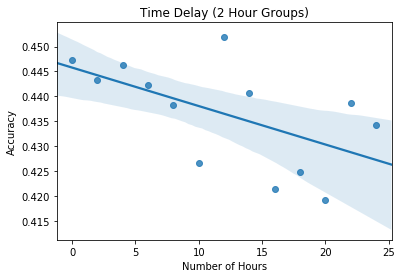

In [385]:
df = pd.DataFrame()
df['Number of Hours'] = list(range(len(score_l)))
df['Accuracy'] = score_l
sb.regplot(x="Number of Hours",y="Accuracy",data=df)
plt.title("Time Delay (2 Hour Groups)")
plt.savefig("time_delay_double.png")

In [386]:
d.shift(0)

In [387]:
print(sum(d.y)/len(d.y))

0.14184397163120568


In [437]:
X_train, X_test, y_train, y_test = train_test_split(d.X, d.Y, test_size=0.2)

             precision    recall  f1-score   support

         -1       0.80      0.22      0.35        18
          0       0.57      0.64      0.60        25
          1       0.38      0.64      0.47        14

avg / total       0.60      0.51      0.49        57

0.5087719298245614


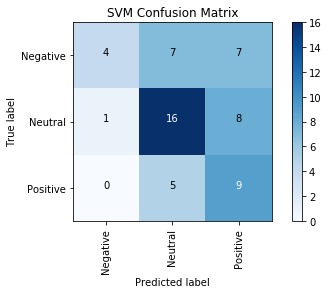

In [452]:
clf = svm.SVC(kernel='linear',C=0.75)
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test,predictions)
plot_confusion_matrix(cnf_matrix,['Negative','Neutral','Positive'],title="SVM Confusion Matrix")
print(classification_report(y_test,predictions))
print(clf.score(X_test,y_test))
plt.savefig("svm_cm.png")

             precision    recall  f1-score   support

         -1       0.57      0.22      0.32        18
          0       0.62      0.72      0.67        25
          1       0.38      0.57      0.46        14

avg / total       0.55      0.53      0.51        57

0.5263157894736842


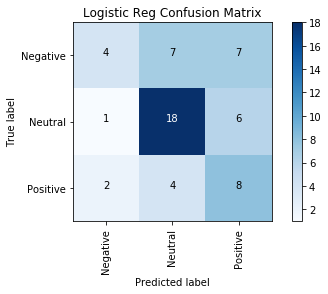

In [445]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test,predictions)
plot_confusion_matrix(cnf_matrix,['Negative','Neutral','Positive'],title="Logistic Reg Confusion Matrix")
print(classification_report(y_test,predictions))
print(clf.score(X_test,y_test))
plt.savefig("log_cm.png")

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        18
          0       0.51      0.84      0.64        25
          1       0.38      0.43      0.40        14

avg / total       0.32      0.47      0.38        57

0.47368421052631576


/Users/moslin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


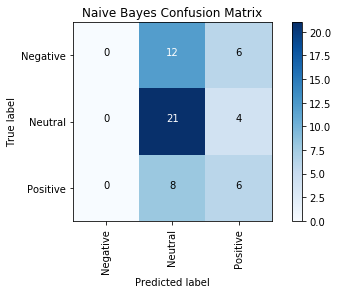

In [446]:
clf = MultinomialNB()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test,predictions)
plot_confusion_matrix(cnf_matrix,['Negative','Neutral','Positive'],title="Naive Bayes Confusion Matrix")
print(classification_report(y_test,predictions))
print(clf.score(X_test,y_test))
plt.savefig("nb_cm.png")

             precision    recall  f1-score   support

         -1       0.43      0.56      0.49        18
          0       0.53      0.72      0.61        25
          1       0.00      0.00      0.00        14

avg / total       0.37      0.49      0.42        57

0.47368421052631576


/Users/moslin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


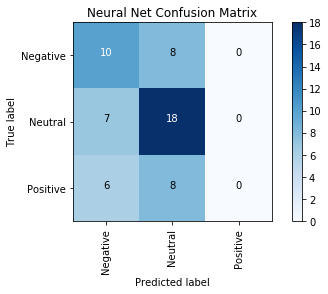

In [447]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50))
mlp.fit(X_train,y_train)
predictions = mlp.predict(X_test)
cnf_matrix = confusion_matrix(y_test,predictions)
plot_confusion_matrix(cnf_matrix,['Negative','Neutral','Positive'],title="Neural Net Confusion Matrix")
print(classification_report(y_test,predictions))
print(clf.score(X_test,y_test))
plt.savefig("nn_cm.png")

In [450]:
svc = svm.SVC(kernel='linear')
parameters = {'C':[0.75, 1.0, 1.25, 1.5]}#,'kernel':('linear', 'rbf')}
clf = GridSearchCV(svc, parameters)
clf.fit(d.X, d.Y)
print(clf.best_params_)
print(clf.best_score_)

{'C': 0.75}
0.4092526690391459


             precision    recall  f1-score   support

         -1       1.00      1.00      1.00        72
          0       1.00      1.00      1.00       116
          1       1.00      1.00      1.00        93

avg / total       1.00      1.00      1.00       281



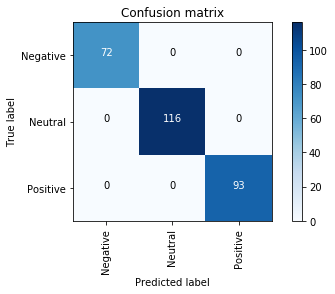

In [451]:
predictions = clf.predict(d.X)
cnf_matrix = confusion_matrix(d.Y,predictions)
plot_confusion_matrix(cnf_matrix,['Negative','Neutral','Positive'])
print(classification_report(d.Y,predictions))